In [8]:
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_dir = "/lsdf/data/activity/MIADatasetOfficial"
save_dir = "/lsdf/data/activity/MIADatasetOfficial"

In [3]:
def find_files(base_dir, pattern="emgvalues.npy"):
    matches = []
    for root, _, filenames in tqdm(os.walk(base_dir)):
        for filename in filenames:
            if filename == pattern:
                matches.append(os.path.join(root, filename))
    return matches


# Search and list all .npy files in the specified directory and its subdirectories.
file_list = find_files(data_dir)
print(len(file_list))

0it [00:00, ?it/s]

24663it [04:47, 85.76it/s] 

24340


In [11]:
file_list[:10]
extract_metadata = lambda path: tuple(path.split(os.path.sep)[-5:-1])

metadata = list(map(extract_metadata, file_list))

columns = ["Split", "Subject", "Activity", "Repetition"]

# Convert the list of tuples into a DataFrame
mia_metadata = pd.DataFrame(metadata, columns=columns)
mia_metadata

,Split,Subject,Activity,Repetition
0,train,Subject3,HighKick,848
1,train,Subject3,HighKick,886
2,train,Subject3,HighKick,836
3,train,Subject3,HighKick,878
4,train,Subject3,HighKick,874
...,...,...,...,...
24335,val,Subject7,RonddeJambe,302
24336,val,Subject7,RonddeJambe,298
24337,val,Subject7,RonddeJambe,307
24338,val,Subject7,RonddeJambe,299


In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed


def process_file(file):
    data = np.load(file)
    if np.isnan(data).any():
        print(file)
        return None
    return data


data_list = []  # Create an empty list to hold data arrays from each file.

# with ThreadPoolExecutor() as executor:
#    futures = {executor.submit(process_file, file): file for file in file_list}
#    for future in tqdm(as_completed(futures), total=len(futures)):
#        result = future.result()
#        if result is not None:
#            data_list.append(result)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, file) for file in file_list]
    for future in tqdm(futures, total=len(futures)):
        result = future.result()
        if result is not None:
            data_list.append(result)

100%|██████████| 24340/24340 [00:08<00:00, 2724.91it/s]


In [29]:
hist, bin_edges = np.histogram(data[:, 0], bins=10)  # Plot a histogram of the concatenated data.
print(hist, bin_edges)
np.set_printoptions(precision=2, suppress=True)
print(hist / np.sum(hist) * 100)

[616688  87852  18741   5085   1317    339    117     39     17      5] [  1.   42.3  83.6 124.9 166.2 207.5 248.8 290.1 331.4 372.7 414. ]
[84.45 12.03  2.57  0.7   0.18  0.05  0.02  0.01  0.    0.  ]


In [55]:
np.save(os.path.join(save_dir, "99pct.npy"), np.percentile(data, 99, axis=0))

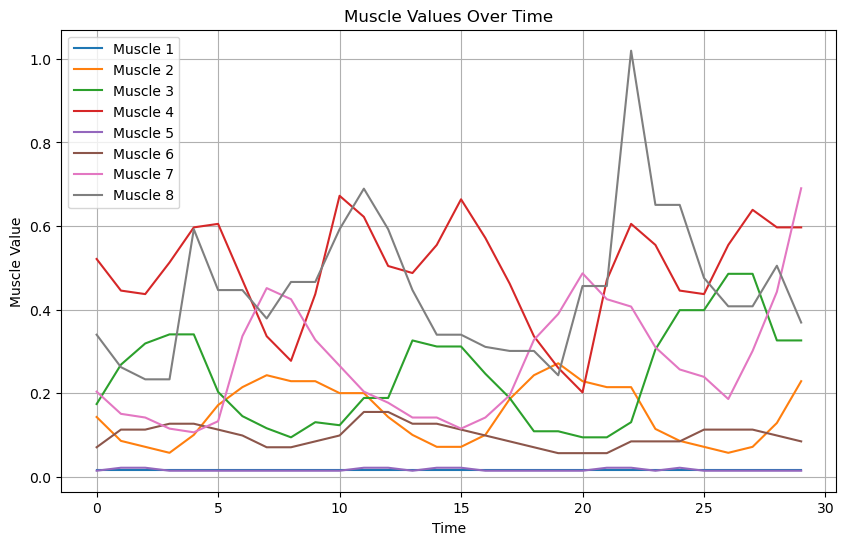

In [74]:
# Plotting
sample = np.load(file_list[8000])
scaled_data = sample / np.percentile(data, 99, axis=0)

plt.figure(figsize=(10, 6))
for i in range(scaled_data.shape[1]):
    plt.plot(scaled_data[:, i], label=f"Muscle {i+1}")

plt.xlabel("Time")
plt.ylabel("Muscle Value")
plt.title("Muscle Values Over Time")
plt.legend()
plt.grid(True)
plt.show()